In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

# TODOs (from 09.06.2020)

1. Strip away the non-useful functions
2. Document the remaining functions
3. Move the remaining functions to modules
4. Test the modules
5. Clean up this NB

# Introduction: movement analysis

From a sequence of signaling events, _eg_ GPS measurements, determine locations where the user remains for a significant duration of time, called "stays". For each of these, there should be a beginning and end, as well as a location. 

Generally, this is meant for movement on the surface of the earth, but for present purposes, it is easiest to illustrate in one spatial dimension "1D"; all of the problems and strategies can be generalized to 2D as needed.

**Note** the signaling events for a given user, form a set $\mathcal{E} :=  \{e_i = (\mathbf{x}_i, t_i), i=[0,N-1] \; | \; t_{i+1}>t_i\}$

In [5]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

dsec = 1/3600.0
time = np.arange(0,24,dsec)
stays = [
        get_stay(  0.00,  6.00,-1.00), #home
        get_stay(  7.50, 16.50, 1.00), #work, afternoon
        get_stay( 18.00, 24.00,-1.00)  # overnight
    ]

t_segs, x_segs = get_stay_segs(stays)


raw_journey = get_journey_path(time, get_segments(time, stays, threshold=0.5))


dup_mask = get_mask_with_duplicates(time, 0.05, 0.3)

time_sub = time[dup_mask]
raw_journey_sub = raw_journey[dup_mask]

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays)      

noises = get_noise_arr(0.02, 0.15, len(segments))

noise_segments = get_noisy_segs(segments, noises)

noise_journey_sub = get_noisy_path(time_sub, raw_journey_sub, noise_segments)

**Figure** in the above plot, time is on the "x"-axis. An interpretation of this motion, is that the user is initially making a "stay" at a location near $x=-1$, then makes another stay at $x=1$, ending with a return to the initial location. As with all of this data, there is an intrinsic noise that must be considered.

# Goal: Stay detection and positioning

The goal is to identify stays by their beginnings and ends, and associate them to a position. This effectively means to optimally match clusters of points with flat lines.

For a set of events within a cluster $\mathcal{C}_l =  \{e_i \; | \; i = [m,n]_l \subset [0,N-1]\}$, a "flat line" has $|\mathbf{x}_m-\mathbf{x}_n| = 0$. Again, this is easiest to see in 1D but it also holds in 2D.


# Strategy

To find the stays, we consider some requirements.

Firstly, there are two main requirements (previously noted):
1. identify the start/stop of a stay
2. estimate a dominant location, _ie_ the "central location" of the stay
    * this is where the agent spends the majority of the time, _e.g._ within a building, at a park, etc.

Then, there are some minor rquirements:
1. the clusters should contain a minimum number of points
2. the duration between the first and last points should exceed $\Delta t$
3. the clusters should be as long (in time) as possible
    * if there is a sufficient temporal break between two consecutive events without a significant location change, then on must specify how this is to be dealt with.
4. the clusters should contain as many events as possible

One additional requirement which affects all of the above: **cluster outliers should be identified and ignored** 
* outliers can change the central location and also the beginning/ending of the clusters
* from the calculation of the central location
    * counting them could still help in identifying a cluster wihtout using their position
    
All of these must be considered together.

This clearly defines an optimization problem: 
* maximize the length of the fit line, while 
    * mimimizing its error by adjusting its position ($\mathrm{x}_{\mathrm{opt.}}$) and end-regions ($t_{\mathrm{start}}, t_{\mathrm{stop}}$)
    * ignoring the outliers.

**Notes** 

* When the error is the mean squared error: $\epsilon := \sqrt{ \frac{1}{N}\sum^N_i(\mathrm{x}_i-\mathrm{x}_{\mathrm{opt.}})^2}$; 
    * this simplifies the position since the mean (or "centroid") is the value of $\mathrm{x}_{\mathrm{opt.}}$ which minimizes this error, leaving only the adjustment of the end-regions and outliers for the optimization task.

This suggests that there is at least a solution to this problem: 
One could consider all possible combinations of subsequences and all possible combinations of their outliers, and measure error, and then pick any from the set of lowest error subsequence-outlier combination fits. However, this is similar to the maximum subarray problem, and in the worst case it would be $\mathcal{O}(n^3)$.

It's countably finite, but impractical approach; itcan be a benchmark to compare all other algorithms which aim to do the same within some acceptable error.

### The Box

In [6]:
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

In [7]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [8]:
eps = 0.25

## Testing the box method

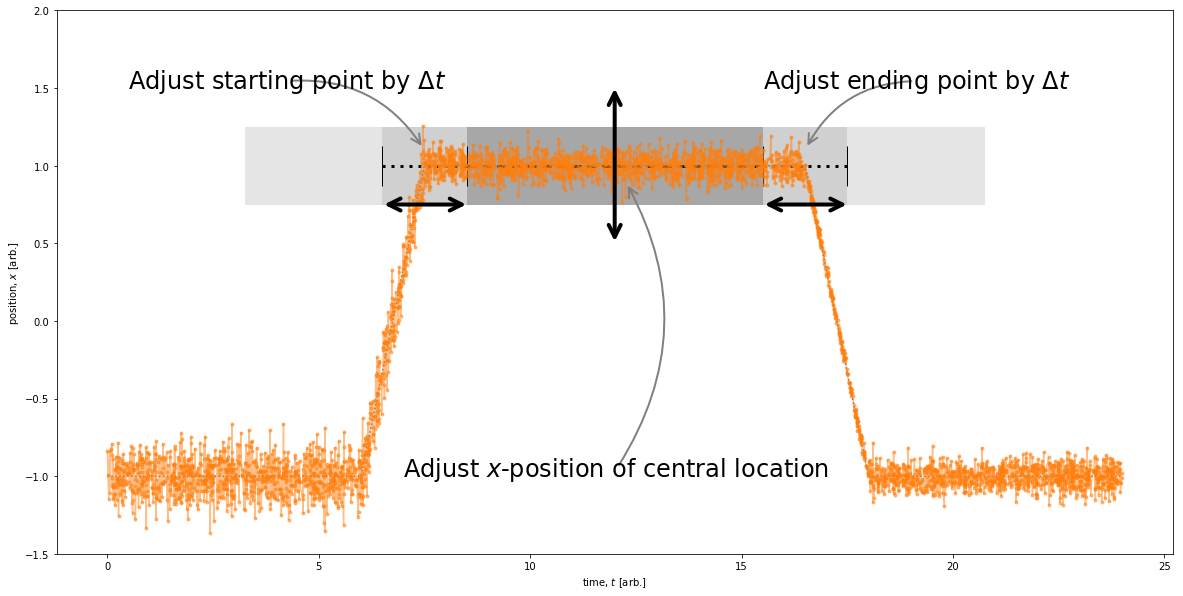

In [9]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

begin = t_segs[3]+1
begin_buff = begin-2
end = t_segs[4]-1
end_buff = end+2

loc = x_segs[3]


rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# The adjusted rwa-stays
#plt.plot(t_segs, x_segs, '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot([begin,end], [loc,loc], 'k--', dashes=[3,2], linewidth=3.0)

ax.plot([begin_buff,begin], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)
ax.plot([end,end_buff], [loc,loc], color='k', marker='|', markersize=40.0, dashes=[1,2], linewidth=3.0)

#plt.plot(t_segs[3:5], x_segs[3:5], '--', marker='o', color='k', linewidth=4.0, markerfacecolor='w', markersize=6.0, markeredgewidth=2.0, label='adjusted raw stays')

ax.plot(time_sub, raw_journey_sub, ':', label='raw journey')
ax.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)




rect_inner = Rectangle((begin, loc-eps), end-begin, 2*eps)
rect_outer = Rectangle((begin_buff, loc-eps), end_buff-begin_buff, 2*eps)
rect_outer2 = Rectangle((begin_buff/2, loc-eps), end+(begin-begin_buff), 2*eps)

# Create patch collection with specified colour/alpha
pc = PatchCollection([rect_outer2], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)
# Create patch collection with specified colour/alpha
pc1 = PatchCollection([rect_outer], \
                     facecolor='gray', alpha=0.2, edgecolor='k',linewidth=0)

pc2 = PatchCollection([rect_inner], \
                     facecolor='gray', alpha=0.5, edgecolor='k',linewidth=0)


# Add collection to axes
ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_collection(pc2)


# interface tracking profiles
arrowprops=dict(arrowstyle="<->", 
                shrinkA=0.5,
                mutation_scale=30.0,
                connectionstyle="arc3", linewidth=4.0)
# the arrows
arrowcentery = 1.0
arrowcenterx = 12
arrowcenterh = 0.5
ax.annotate("", xy=(arrowcenterx, arrowcentery-arrowcenterh), xytext=(arrowcenterx, arrowcentery+arrowcenterh),
             arrowprops=arrowprops)

dt_arrowcentery = 0.25
ax.annotate("", xy=(begin_buff, arrowcentery-dt_arrowcentery), xytext=(begin, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)

ax.annotate("", xy=(end, arrowcentery-dt_arrowcentery), xytext=(end_buff, arrowcentery-dt_arrowcentery),
             arrowprops=arrowprops)


mid_point = lambda x1,x2: 0.5*(x1+x2)

delta_t_texty = 1.5
ax.annotate(r"Adjust starting point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(begin,begin_buff), 1.1), xycoords='data',
            xytext=(begin-8,delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=-0.3", linewidth=2.0
                            ),
            )
ax.annotate(r"Adjust ending point by $\Delta t$", fontsize=24.0,
            xy=(mid_point(end,end_buff), 1.1), xycoords='data',
            xytext=(end, delta_t_texty), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

ax.annotate(r"Adjust $x$-position of central location",fontsize= 24,
            xy=(arrowcenterx+0.25, arrowcentery-0.1), xycoords='data',
            xytext=(arrowcenterx-5, arrowcentery-2.0), textcoords='data',
            arrowprops=dict(arrowstyle="->", color="0.5",
                            shrinkA=5, shrinkB=5,
                            patchA=None, patchB=None,
                            connectionstyle="arc3,rad=0.3", linewidth=2.0
                            ),
            )

'''plt.text(0, 0.1, r'$\delta$',
         {'color': 'black', 'fontsize': 24, 'ha': 'center', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="white", ec="black", pad=0.2)})
'''
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')
plt.ylim(-1.5, 2)
plt.grid(visible=False);

Once the box (width is provided by the spatial tolerance) is positioned in a good way (_ie_ the centroid), extending the box forwards or backwards in time makes no change to the _score_ of the box.

Here, the score could be something like the number of points, the std/MSE; whatever it is, it should be saturated at some point and extending the box makes no difference, meaning that something converges which provides a stopping criterion. 

In [10]:
rand_range = lambda size, max_, min_: (max_-min_)*np.random.random_sample(size=size) + min_

In [123]:
from synthetic_data.trajectory import get_stay
from synthetic_data.trajectory import get_journey_path, get_segments
from synthetic_data.masking import get_mask_with_duplicates
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays, get_stay_indices
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr
from synthetic_data.noise import get_noisy_segs, get_noisy_path, get_noise_arr

In [12]:
from synthetic_data.trajectory_class import get_trajectory

In [13]:
dsec = 1/3600.0
time = np.arange(0,24,dsec)

In [14]:
segs_plot_kwargs = {'linestyle':'--', 'marker':'o', 'color':'k', 'linewidth':4.0, 'markerfacecolor':'w', 'markersize':6.0, 'markeredgewidth':2.0}

In [572]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [ ]:
event_frac = rand_range(1,0.01,0.001)[0]

duplicate_frac = rand_range(1,0.3,0.05)[0]

print(event_frac, duplicate_frac)

configs = {
    'threshold':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}


nr_stays = np.random.randint(10)
stay_time_bounds = np.concatenate((np.array([0]),rand_range(2*nr_stays, 24, 0),np.array([24])))
stay_time_bounds = np.sort(stay_time_bounds)
stay_xlocs = rand_range(nr_stays+1, 2, - 2.0)

```
stays = []
for n in range(nr_stays+1):
    
    nn = 2*n
    stay = get_stay(stay_time_bounds[nn], stay_time_bounds[nn+1],  stay_xlocs[n])
    #print(n,nn,nn+1,stay)
    stays.append(stay)
    

time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)

segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays) 
```

### Check the trajectory

In [567]:
time_thresh = 1/6 # 10 mins

In [568]:
new_stay_time_bounds = []
new_stay_xlocs = []
for n in range(len(stay_xlocs)):
    
    nn = 2*n
    b0,b1 = stay_time_bounds[nn],stay_time_bounds[nn+1]

    if b1-b0 > time_thresh: 
        
        new_stay_time_bounds.extend([b0,b1])
        new_stay_xlocs.append(stay_xlocs[n])

In [569]:
configs = {
    'threshold':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}


stays = []
for n in range(int(len(new_stay_time_bounds)/2)):
    
    nn = 2*n
    stay = get_stay(new_stay_time_bounds[nn], new_stay_time_bounds[nn+1], new_stay_xlocs[n])
    #print(n,nn,nn+1,stay)
    stays.append(stay)
    

In [570]:
time_sub, raw_journey_sub, noise_journey_sub = get_trajectory(stays, time, configs)
segments = get_segments(time, stays, threshold=0.5)
new_stays = get_adjusted_stays(segments, time_sub)
new_t_segs, new_x_segs = get_stay_segs(new_stays) 

#### Plot new vs old

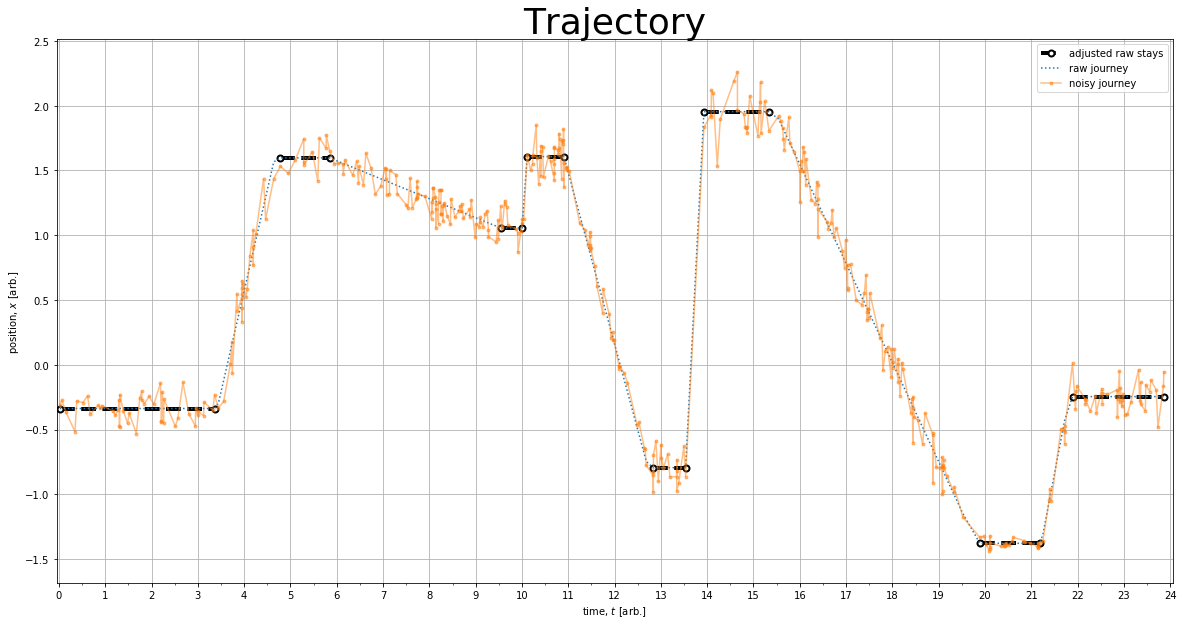

In [571]:
plt.figure(figsize=(20,10))
#plt.plot(t_segs, x_segs, ':', marker='|', color='grey', linewidth=2.0, markerfacecolor='w', markersize=30.0, markeredgewidth=1.0, dashes=[0.5,0.5], label='raw stays')

plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
plt.plot(time_sub, raw_journey_sub, ':', label='raw journey')
plt.plot(time_sub, noise_journey_sub, '.-', label='noisy journey', alpha=0.5)

plt.legend();

plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)

ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(-0.05, 24.05)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Trajectory', fontsize=36)
plt.grid(visible=True);

### Save the trajectory

In [573]:
trajectory = {}

trajectory['segments'] = segments
trajectory['time_arr'] = time_sub
trajectory['raw_locs_arr'] = raw_journey_sub
trajectory['nse_locs_arr'] = noise_journey_sub

In [574]:
import pickle

In [575]:
from datetime import datetime

In [576]:
date_tag = datetime.today().strftime("%Y%m%d")
len_tag = str(len(new_stays))
extension = '__adjusted'
trajectory_tag = f'{date_tag}_trajectory_{len_tag}stays{extension}.pkl' 
print(trajectory_tag)

20200625_trajectory_8stays__adjusted.pkl


In [577]:
pickle.dump( trajectory, open( trajectory_tag, "wb" ) )
#trajectory = pickle.load( open( "save.p", "rb" ) )

In [18]:
def time_overlap(t0,t1,tt0,tt1):
    
    if ((t0>=tt0)&(t0<tt1)):
        return True
    elif ((t1>=tt0)&(t1<tt1)):
        return True
    elif ((t0 <= tt0) & (tt1 <= t1)):
        return True
    else:
        return False

In [122]:
new_stays

[{'type': 'stay',
  'loc': -1.7585104235909235,
  'start': 0.017777777777777778,
  'end': 5.224722222222222,
  'slope': 0},
 {'type': 'stay',
  'loc': 1.7425210839355314,
  'start': 14.035,
  'end': 15.898055555555555,
  'slope': 0},
 {'type': 'stay',
  'loc': -0.3044636676556389,
  'start': 17.75138888888889,
  'end': 23.9425,
  'slope': 0}]

In [19]:
def check_true(t_s, t_l, tsegs):
    for t_1, t_2 in zip(tsegs.tolist()[::3],tsegs.tolist()[1::3]):
        if time_overlap(t_s, t_l, t_1, t_2 ): 
            return t_1, t_2

## Testing

**Note** 
* a box will extend too _far_ when
    * if the duration of constant mean is too long, 
    * if the number of events for a constant mean is too large
        * **!** need to consider numbers of samples because the samples can increase but time-delta not
* a box will cut too _early_ when
    * if the number of events for a temporal constant mean is too large
* The embedding  conditional really drops a lot of small and other stays.

**TODOs**

1. Make the new scripts into a new module 'box_classifier'

2. include a `for` classifier in the above

3. Rewrite the `for` classifier into a `while` classifier

In [20]:
from stay_classification.box_classifier.box_classify import box_classifier_core

In [578]:
configs = {
    'eps':0.25,
    'time_thresh':1/6,
    'slope_time_thresh':1.0,
    'slope_thresh':0.50,
    'count_thresh':50
}

In [579]:
eps = configs['eps']
time_thresh = configs['time_thresh']
slope_time_thresh = configs['slope_time_thresh']  
slope_thresh = configs['slope_thresh']
count_thresh = configs['count_thresh']

### Run 1


PLOT: ID #  1 - - - - - - - - - - - - - - - - - - - - - - - -
	0.020 0, 47 True: ; Pred: 0.020, 3.559 -0.338 


PLOT: ID #  2 - - - - - - - - - - - - - - - - - - - - - - - -
	0.270 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  3 - - - - - - - - - - - - - - - - - - - - - - - -
	0.520 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  4 - - - - - - - - - - - - - - - - - - - - - - - -
	0.770 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  5 - - - - - - - - - - - - - - - - - - - - - - - -
	1.020 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  6 - - - - - - - - - - - - - - - - - - - - - - - -
	1.270 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  7 - - - - - - - - - - - - - - - - - - - - - - - -
	1.520 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  8 - - - - - - - - - - - - - - - - - - - - - - - -
	1.770 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  9 - - - - - - - - - - - - - - - - - - - - - - - -
	2.020 1, 47 True: ; Pred: 0.065, 3.559 -

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


 True: ; Pred: 13.929, 16.095 1.855 


PLOT: ID # 63 - - - - - - - - - - - - - - - - - - - - - - - -
	16.020 257, 293 True: ; Pred: 13.929, 16.095 1.846 


PLOT: ID # 64 - - - - - - - - - - - - - - - - - - - - - - - -
	16.270 284, 300 True: ; Pred: 15.664, 16.391 1.484 


PLOT: ID # 65 - - - - - - - - - - - - - - - - - - - - - - - -
	16.520 289, 311 True: ; Pred: 16.000, 16.988 1.181 


PLOT: ID # 66 - - - - - - - - - - - - - - - - - - - - - - - -
	16.770 289, 311 True: ; Pred: 16.000, 16.988 1.181 


PLOT: ID # 67 - - - - - - - - - - - - - - - - - - - - - - - -
	17.020 289, 311 True: ; Pred: 16.000, 16.988 1.113 


PLOT: ID # 68 - - - - - - - - - - - - - - - - - - - - - - - -
	17.270 310, 327 True: ; Pred: 16.966, 17.770 0.532 


PLOT: ID # 69 - - - - - - - - - - - - - - - - - - - - - - - -
	17.520 312, 327 True: ; Pred: 17.031, 17.770 0.440 


PLOT: ID # 70 - - - - - - - - - - - - - - - - - - - - - - - -
	17.770 312, 327 True: ; Pred: 17.031, 17.770 0.440 


PLOT: ID # 71 - - - - - -

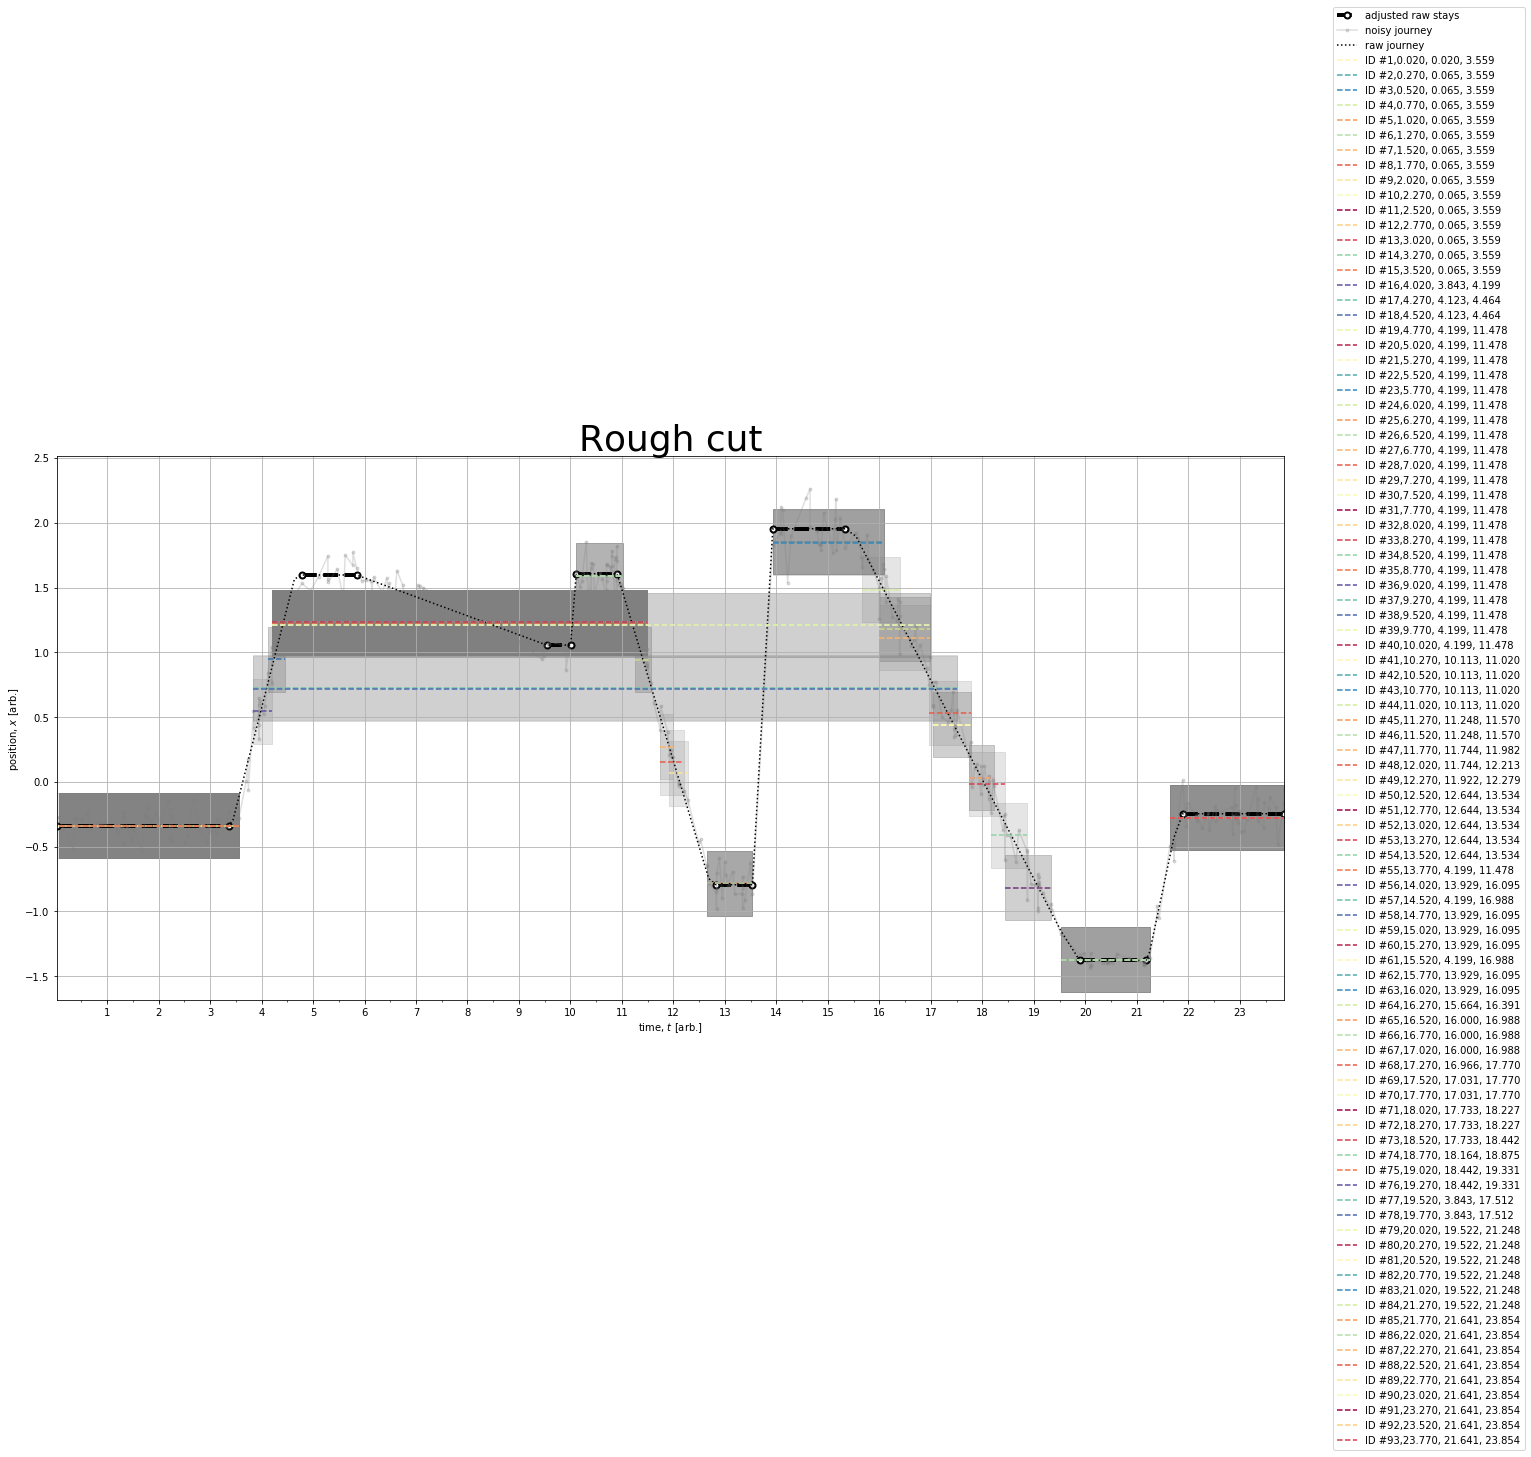

In [580]:
min_t, max_t = time_sub.min(), time_sub.max()

fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0
t_diff = abs(time_sub[t1]-time_sub[t0])

for timepoint in np.arange(min_t,max_t,0.25):
   
    start_ind, last_ind, mean, keep = box_classifier_core(time_sub, noise_journey_sub, start_ind, last_ind, timepoint, pairs, configs, False)

    if keep:
        pairs.append([start_ind, last_ind,])
        nnn += 1
    else:
        continue

    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[start_ind]
    t_last = time_sub[last_ind]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    #t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    '''if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    '''
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{start_ind}, {last_ind}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn%len(colors)], \
            label=f'ID #{nnn},{timepoint:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    '''
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    '''
    # Add the box
    t_diff = time_sub[last_ind] -time_sub[start_ind]
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[start_ind], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

```
def get_stay_indices(segs, time_subarr):
    """
    Adjust the stay boundaries after the masking, as there is a reduction in the number of events

    :param segs: [list(dict)] segment dictionary
    :param time_subarr:  [np.array] reduced time-array (after masking)
    
    :return: [list(dict)] List of new stays
    """
    
    new_stays = []
    
    for start_, stop_  in zip(segs[::3],segs[1::3]):

        #start_, stop_ ,_ = seg 

        ####TODO: generalize to any seg, since the travels are also affected.
        #if  type_ == 'stay':
        subarr = np.where((time_subarr >= start_) & \
                                    (time_subarr <= stop_))[0]

        new_t0, new_t1 = np.min(subarr),np.max(subarr)        

        new_stays.append((new_t0,new_t1))
        
    return new_stays
```    

In [581]:
from collections import Counter

In [582]:
tpl_pairs = []
for pair in pairs:
    tpl_pairs.append(tuple(pair))

In [583]:
Counter(tpl_pairs)

Counter({(0, 47): 1,
         (1, 47): 14,
         (51, 64): 1,
         (62, 68): 2,
         (63, 218): 23,
         (175, 210): 4,
         (211, 220): 2,
         (222, 228): 1,
         (222, 232): 1,
         (225, 233): 1,
         (236, 256): 5,
         (257, 293): 6,
         (63, 311): 2,
         (284, 300): 1,
         (289, 311): 3,
         (310, 327): 1,
         (312, 327): 2,
         (326, 341): 2,
         (326, 346): 1,
         (339, 353): 1,
         (344, 366): 2,
         (51, 325): 2,
         (367, 394): 6,
         (398, 439): 9})

In [584]:
set1 = set(range(tpl_pairs[0][0],tpl_pairs[0][1]))
set2 = set(range(114,169))
print(tpl_pairs[2], set2)
print(len(set2.intersection(set1))/len(set2))

(1, 47) {128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
0.0


In [288]:
print(set2.intersection(set1))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128}


In [447]:
1

1

### Iterative

**TODO** add some documentation here to describe what's going on.

In [590]:
multiple_pairs = []

time_deltas = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.3] # Tried this, but was okay
time_deltas = np.arange(-1/30,4/30, 1/30) # This was a little better, but not by much.

print(len(time_deltas))

for time_delta in np.array(time_deltas):
    tmp_pairs = []
    
    timepoints = np.arange(min_t+time_delta,max_t,1/6.) #(min_t+time_delta,max_t,1/6.)
    print(timepoints.size)
    for timepoint in timepoints:

        start_ind, last_ind, mean, keep = box_classifier_core(time_sub, noise_journey_sub, start_ind, last_ind, timepoint, pairs, configs, False)

        if keep:
            tmp_pairs.append((start_ind, last_ind))
            multiple_pairs.append([start_ind, last_ind])
            nnn += 1
        else:
            continue
    print(Counter(tmp_pairs))

5
144
Counter({(63, 218): 33, (1, 47): 17, (257, 293): 12, (398, 439): 12, (367, 394): 8, (175, 210): 7, (236, 256): 7, (0, 47): 6, (51, 64): 4, (344, 366): 4, (51, 327): 4, (289, 311): 3, (312, 327): 3, (62, 68): 2, (211, 220): 2, (225, 233): 2, (326, 341): 2, (326, 346): 2, (339, 353): 2, (63, 174): 1, (220, 224): 1, (222, 228): 1, (222, 232): 1, (63, 311): 1, (257, 295): 1, (284, 300): 1, (288, 308): 1, (301, 315): 1, (310, 327): 1, (51, 325): 1})
144
Counter({(63, 218): 34, (1, 47): 21, (398, 439): 14, (257, 293): 11, (367, 394): 10, (236, 256): 8, (175, 210): 7, (289, 311): 4, (51, 64): 3, (63, 311): 3, (326, 341): 3, (344, 366): 3, (0, 47): 2, (62, 68): 2, (211, 220): 2, (225, 233): 2, (312, 327): 2, (326, 346): 2, (339, 353): 2, (51, 325): 2, (220, 224): 1, (222, 228): 1, (222, 232): 1, (257, 295): 1, (284, 300): 1, (310, 327): 1})
143
Counter({(63, 218): 36, (1, 47): 21, (398, 439): 13, (257, 293): 12, (367, 394): 10, (236, 256): 7, (175, 210): 6, (51, 64): 3, (225, 233): 3, (2

In [591]:
mult_tpl_pairs = []
for pair in multiple_pairs:
    mult_tpl_pairs.append(tuple(pair))
Counter(mult_tpl_pairs)

Counter({(0, 47): 15,
         (1, 47): 99,
         (51, 64): 15,
         (62, 68): 9,
         (63, 218): 171,
         (63, 174): 2,
         (175, 210): 32,
         (211, 220): 12,
         (220, 224): 4,
         (222, 228): 5,
         (222, 232): 3,
         (225, 233): 12,
         (236, 256): 35,
         (257, 293): 58,
         (63, 311): 11,
         (257, 295): 5,
         (284, 300): 5,
         (288, 308): 2,
         (289, 311): 14,
         (301, 315): 4,
         (310, 327): 7,
         (312, 327): 13,
         (326, 341): 14,
         (326, 346): 7,
         (339, 353): 11,
         (344, 366): 20,
         (367, 394): 44,
         (51, 325): 7,
         (51, 327): 8,
         (398, 439): 67})

In [592]:
final_pairs = {k:int(v/len(time_deltas)) for k,v in Counter(mult_tpl_pairs).items() if int(v/len(time_deltas)) >= len(time_deltas)}

In [593]:
final_pairs

{(1, 47): 19,
 (63, 218): 34,
 (175, 210): 6,
 (236, 256): 7,
 (257, 293): 11,
 (367, 394): 8,
 (398, 439): 13}


PLOT: ID #  0 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 1, 47 True: ; Pred: 0.065, 3.559 -0.339 


PLOT: ID #  1 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 63, 218 True: ; Pred: 4.199, 11.478 1.337 


PLOT: ID #  2 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 175, 210 True: ; Pred: 10.113, 11.020 1.598 


PLOT: ID #  3 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 236, 256 True: ; Pred: 12.644, 13.534 -0.782 


PLOT: ID #  4 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 257, 293 True: ; Pred: 13.929, 16.095 1.839 


PLOT: ID #  5 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 367, 394 True: ; Pred: 19.522, 21.248 -1.373 


PLOT: ID #  6 - - - - - - - - - - - - - - - - - - - - - - - -
	23.787 398, 439 True: ; Pred: 21.641, 23.854 -0.279 



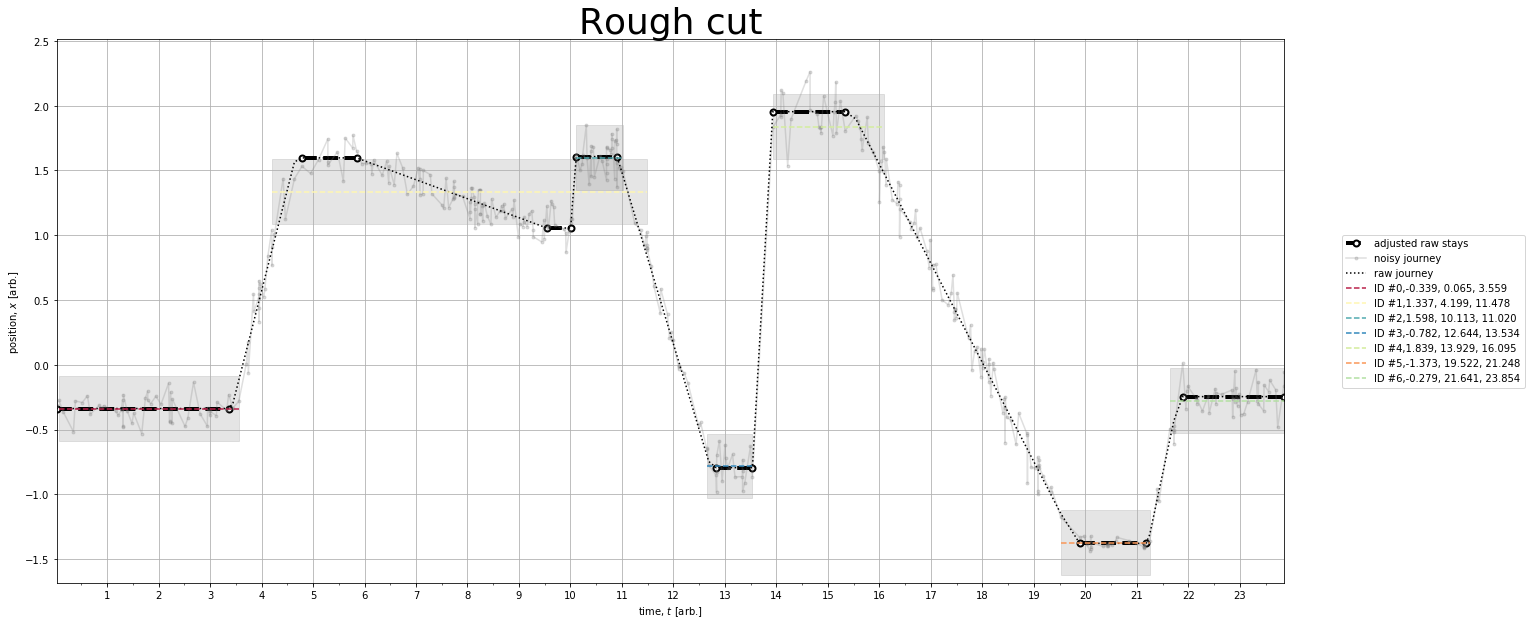

In [595]:
min_t, max_t = time_sub.min(), time_sub.max()

fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0
t_diff = abs(time_sub[t1]-time_sub[t0])

nnn=0
for pair in final_pairs:
   
    start_ind, last_ind = pair
    mean = np.mean(noise_journey_sub[start_ind:last_ind+1])

    # PLOTTING
    dashing = "-"+23*" -"
    ddashing = "="+30*"=="
    
    t_start = time_sub[start_ind]
    t_last = time_sub[last_ind]
    
    '''seg_ind = min(3*nnn+1,len(new_t_segs))
    t_seg_0 = new_t_segs[seg_ind-1]
    t_seg_1 = new_t_segs[seg_ind]'''
    #t_seg_0, t_seg_1 = check_true(t_start, t_last, new_t_segs)
    true_vals = ""
    '''if time_overlap(t_start, t_last, t_seg_0, t_seg_1 ):
        true_vals = f'{t_seg_0:2.3f}, {t_seg_1:2.3f}'    
    else:
        true_vals = 'Unmatched'
    '''
    true_vals = f"True: {true_vals};"

    print(f'\nPLOT: ID #{nnn:3d} {dashing}\n\t{timepoint:.3f}', \
          f'{start_ind}, {last_ind}', \
          true_vals,\
          f'Pred: {t_start:.3f}, {t_last:.3f}',\
          f'{mean:.3f}', \
          f'\n\n{ddashing}')
    
    #print(timepoint,":, mean, start_ind, last_ind)        
    ax.plot([time_sub[start_ind],time_sub[last_ind]], [mean,mean],\
            '--', color=colors[nnn%len(colors)], \
            label=f'ID #{nnn},{mean:.3f}, {time_sub[start_ind]:.3f}, {time_sub[last_ind]:.3f}')
    '''
    t_diff = abs(time_sub[t1]-time_sub[t0])
    ax.plot([time_sub[t0],time_sub[t1]], [mean,mean], '--', \
            dashes=[1,1], linewidth=5, color=colors[nnn], \
            label=f'ID #{nnn}: {round(t_diff,2)}, sub')
    '''
    # Add the box
    t_diff = time_sub[last_ind] -time_sub[start_ind]
    rect_color = "gray" #colors[nnn]
    rect = Rectangle((time_sub[start_ind], mean-eps), t_diff, 2*eps)
    pc = PatchCollection([rect], \
                         facecolor=rect_color, alpha=0.2, edgecolor=rect_color,linewidth=1)
    ax.add_collection(pc)
    
    nnn+=1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps
plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, max_t)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

In [596]:
for k,v in Counter(mult_tpl_pairs).items():
    keep=''
    if int(v/len(time_deltas)) >= len(time_deltas):
        keep='keep'
    print(f'{time_sub[k[0]]:5.3f}\t{time_sub[k[1]]:5.3f}:\t{v:5d}\t{int(v/len(time_deltas)):5d}\t {keep}')

0.020	3.559:	   15	    3	 
0.065	3.559:	   99	   19	 keep
3.843	4.199:	   15	    3	 
4.123	4.464:	    9	    1	 
4.199	11.478:	  171	   34	 keep
4.199	10.038:	    2	    0	 
10.113	11.020:	   32	    6	 keep
11.248	11.570:	   12	    2	 
11.570	11.885:	    4	    0	 
11.744	11.982:	    5	    1	 
11.744	12.213:	    3	    0	 
11.922	12.279:	   12	    2	 
12.644	13.534:	   35	    7	 keep
13.929	16.095:	   58	   11	 keep
4.199	16.988:	   11	    2	 
13.929	16.135:	    5	    1	 
15.664	16.391:	    5	    1	 
15.998	16.789:	    2	    0	 
16.000	16.988:	   14	    2	 
16.391	17.095:	    4	    0	 
16.966	17.770:	    7	    1	 
17.031	17.770:	   13	    2	 
17.733	18.227:	   14	    2	 
17.733	18.442:	    7	    1	 
18.164	18.875:	   11	    2	 
18.442	19.331:	   20	    4	 
19.522	21.248:	   44	    8	 keep
3.843	17.512:	    7	    1	 
3.843	17.770:	    8	    1	 
21.641	23.854:	   67	   13	 keep


10


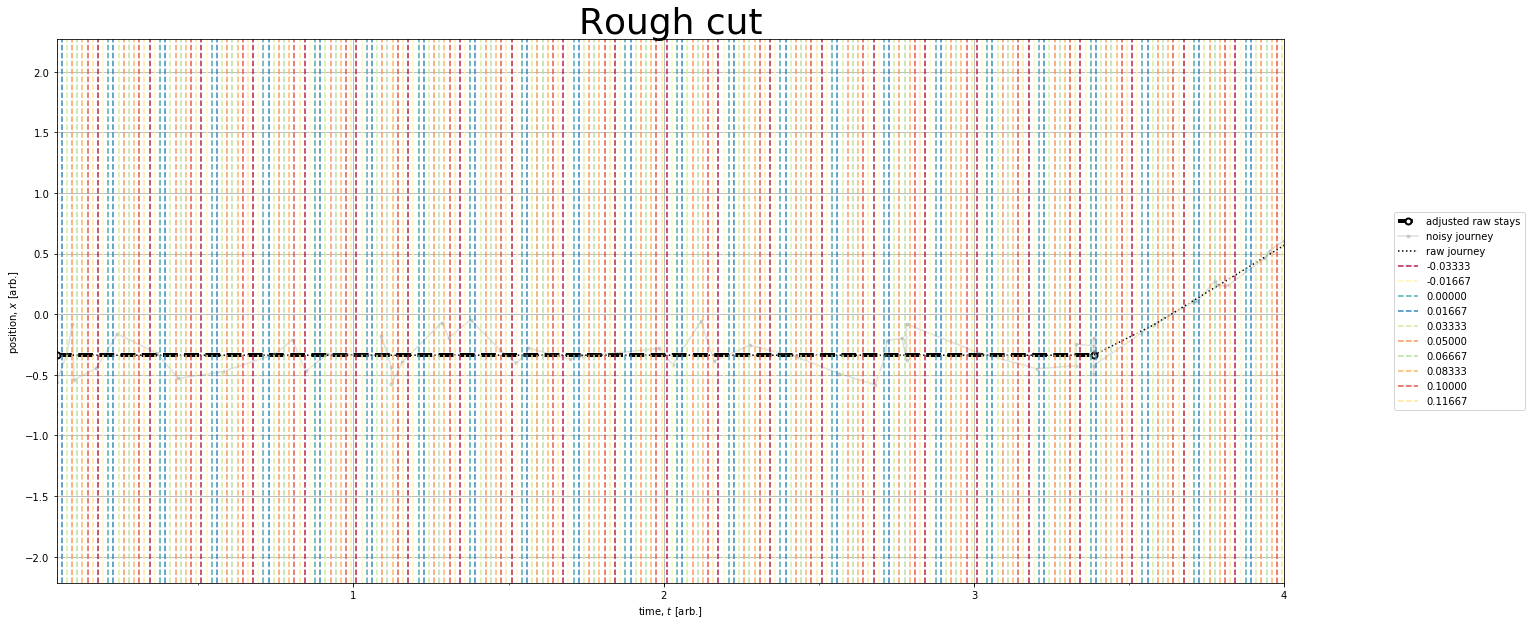

In [454]:
min_t, max_t = time_sub.min(), time_sub.max()

ymin = noise_journey_sub.min()-1*eps
ymax = noise_journey_sub.max()+1*eps

fig, ax = plt.subplots(1,1,figsize=(22,10))

# The adjusted raw-stays
plt.plot(new_t_segs, new_x_segs, **segs_plot_kwargs, label='adjusted raw stays')
ax.plot(time_sub, noise_journey_sub, '.-', color='gray', label='noisy journey', alpha=0.25)
ax.plot(time_sub, raw_journey_sub, ':', color='k', label='raw journey')

t0,t1 = 0,1
start_ind, last_ind = t0, t1

pairs = []

nnn = 0
t_diff = abs(time_sub[t1]-time_sub[t0])

nnn=0

time_deltas = [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.3] # Tried this, but was okay
time_deltas = np.arange(-1/30,4/30, 1/60) # This was a little better, but not by much.

print(len(time_deltas))

for time_delta in np.array(time_deltas):
    label = f'{time_delta:.5f}'
    for timepoint in np.arange(min_t+time_delta,4.0,1/6.):
 
        #print(timepoint,":, mean, start_ind, last_ind)        
        ax.plot([timepoint, timepoint], [ymin,ymax],\
                '--', color=colors[nnn%len(colors)], \
                label=label)
        label=''
    
    nnn+=1
    
plt.xlabel(r'time, $t$ [arb.]')
plt.ylabel(r'position, $x$ [arb.]')

plt.ylim(ymin, ymax)


ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlim(min_t, 4.0)
#plt.xlim(-0.1, 19.1
#plt.xlim(15.1, 19.1)

plt.title('Rough cut', fontsize=36)
plt.grid(visible=True);
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='right', ncol=1);

#### Evaluate

In [395]:
true_indices = get_stay_indices(new_stays, time_sub)

In [396]:
true_labels = np.zeros(time_sub.shape)

In [397]:
for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [398]:
np.sum(true_labels), true_labels.size-np.sum(true_labels), true_labels.size, np.sum(true_labels)/true_labels.size

(224.0, 217.0, 441, 0.5079365079365079)

In [399]:
pred_labels = np.zeros(time_sub.shape)
for pair in final_pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [400]:
np.sum(pred_labels), pred_labels.size-np.sum(pred_labels), pred_labels.size, np.sum(pred_labels)/pred_labels.size

(340.0, 101.0, 441, 0.7709750566893424)

In [401]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [402]:
confusion_matrix(true_labels, pred_labels)

array([[ 86, 131],
       [ 15, 209]])

In [403]:
precision_score(true_labels, pred_labels), recall_score(true_labels, pred_labels), 

(0.6147058823529412, 0.9330357142857143)

Thus in binary classification, the count of 
* true negatives is $C_{0,0}$, 
* false negatives is $C_{1,0}$, 
* true positives is $C_{1,1}$ and 
* false positives is $C_{0,1}$.

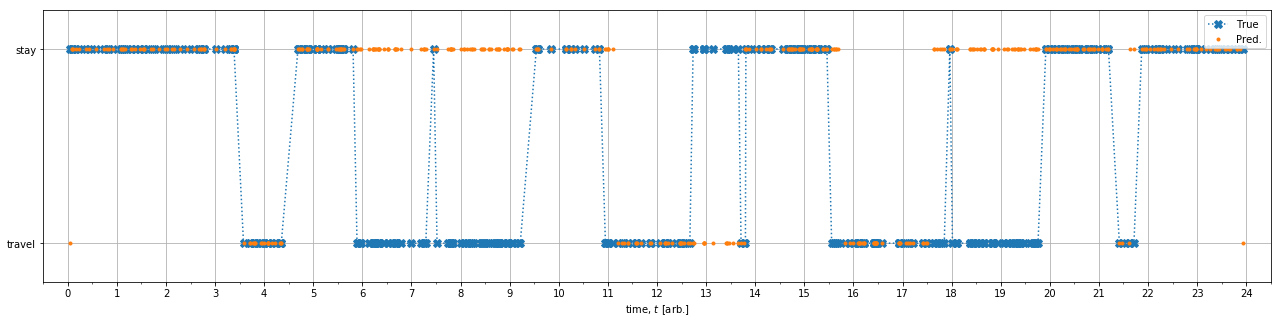

In [404]:
fig, ax = plt.subplots(1,1,figsize=(22,5))

plt.plot(time_sub, true_labels, 'X:', markersize=8, label='True')
plt.plot(time_sub, pred_labels, '.', label='Pred.')
plt.ylim(-0.2,1.2)
plt.xlim(-0.5,24.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])


plt.legend()
plt.grid();

### Testing module

In [445]:
from stay_classification.box_classifier.tests.tests import test__get_time_ind

In [446]:
test__get_time_ind()

True